<a href="https://colab.research.google.com/github/jugal-krishna/Transformer/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages

import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.autograd import Variable
from torchvision import datasets, transforms, models
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import numpy as np

In [ ]:
# Vision transformer

# Import packages

import torch
from torch import nn


# Defining the Vision Transformer Model

# Patch embedding Module

class PatchEmbed(nn.Module):
    """
    Parameters
    img_size: Size of image
    patch_size: size of patch
    in_ch: Num of input channels ( 3 for RGB img)
    embed_dim: embedding dim
    """

    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):  # embed_dim = 768 since i/p size = 256
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # Divide input img into patches
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

        return x


# Attention Module
class Attention(nn.Module):
    """
    Parameters:
    dim : input dimension (= output dimension)
    n_heads : Num of attention heads
    qkv_bias: if True, include bias to Q, K, V
    attn_p: Dropout prob applied to Q, K, V
    proj_p: Dropout prob applied to output

    Attributes:
    scale: Normalizing constant for dot product = sqrt(k)
    qkv: Linear projection into Q, K, V
    proj: Linear mapping to project concatenation of all heads into o/p space dimensions = i/p dim
    """

    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.qkv_bias = qkv_bias
        self.attn_drop = nn.Dropout(attn_p)
        self.proj_drop = nn.Dropout(proj_p)
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        if dim != self.dim:
            raise ValueError
        qkv = self.qkv(x)  # n_samples, n_patches+1, 3*dim
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, n_samples, n_heads, n_patches+1, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k = k.transpose(-2, -1)
        dp = (q @ k
              * self.scale)
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2)
        weighted_avg = weighted_avg.flatten(2)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x


# Multi layer perceptron

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)

        return x


# Transformer block

class Block(nn.Module):
    """
    Parameters:
    dim : int
      Embedding dimension
    n_heads : int
      Num of attention heads
    mlp_ratio : int
      Ratio of hidden dim features to i/p features of MLP
    qkv_bias : bool
       If True, adds bias to the Q, K, V projections
    p, attn_p : float
       Droupout prob

    Attributes:
    norm1, norm2: Normalization layers
    attn: Attention module
    mlp: MLP module
    """

    def __init__(self, dim, n_heads, mlp_ratio=4, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads=n_heads,
                              qkv_bias=qkv_bias,
                              attn_p=attn_p,
                              proj_p=proj_p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = dim * mlp_ratio
        self.mlp = MLP(in_features=dim,
                       hidden_features=hidden_features,
                       out_features=dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


# Vision Transformer

class VisionTransformer(nn.Module):
    """
    Parameters:

    img_size : int
        h,w of img (square)
    patch_size : int
        h,w of patch size
    in_chans : int
        Num of i/p channels
    n_classes : int
        Num of classes
    embed_dim : int
        Dimensionality of token embeddings
    depth : int
        Num of blocks
    n_heads : int
        Num of attention heads
    mlp_ratio : int
        Ratio of hidden dim features to i/p features of MLP
    qkv_bias : bool
        If True, add bias to Q, K, V
    proj_p, attn_p : float
        Dropout probabilities for projection and attention layers

    Attributes:

    patch_embed : PatchEmbed
        Instance of the 'PatchEmbed' layer
    cls_token : nn.Parameter
        Learnable parameter that represent 1st token of sequence
    pos_embed : nn.Parameter
        Positional embedding

    """

    def __init__(self, img_size=384, patch_size=16,
                 in_chans=3, n_classes=1000, embed_dim=768,
                 depth=12, n_heads=12, mlp_ratio=4, qkv_bias=True,
                 proj_p=0., attn_p=0.):
        super().__init__()

        self.patch_embed = PatchEmbed(img_size=img_size,
                                      patch_size=patch_size,
                                      in_chans=in_chans,
                                      embed_dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(proj_p)
        self.blocks = nn.ModuleList(
            [
                Block(dim=embed_dim, n_heads=n_heads,
                      mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                      proj_p=proj_p, attn_p=attn_p)
                for _ in range(depth)
            ]
        )
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)

        return x


In [ ]:


train_data = datasets.CIFAR100(download=True,root="./data",transform=transforms.ToTensor())
test_data = datasets.CIFAR100(root="./data",train=False,transform=transforms.ToTensor())

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


In [ ]:
# Mean and std of images in a dataset
def compute_mean_std(dataset):
    meanRGB = [np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset]
    stdRGB = [np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    return [meanR, meanG, meanB], [stdR, stdG, stdB]

In [ ]:
tr_mean, tr_std = compute_mean_std(train_data)
test_mean, test_std = compute_mean_std(test_data)

In [ ]:
tr_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(tr_mean, tr_std)])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(test_mean, test_std)])

In [ ]:
train_data.transform = tr_transform
test_data.transform = test_transform

In [ ]:
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

In [ ]:
print(torch.cuda.device_count())

1


In [ ]:


# Training

class Trainer:

    def train(self, model, lr, optimizer, epochs):

        # Model

        criterion = torch.nn.CrossEntropyLoss().cuda()  # Loss function to use

        # train loop

        model.train()
        train_running_loss = 0
        tr_acc = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = Variable(inputs).cuda()
            optimizer.zero_grad()
            pred = model(inputs)
            loss = criterion(pred, labels.cuda())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()
            for j in range(len(labels)):
              if torch.argmax(pred[j,:]).detach().cpu() == labels[j] :
                tr_acc+=1
        train_loss = train_running_loss / len(train_loader)
        tr_acc = tr_acc/ (len(train_loader)*len(labels))
        # Validation loop

        model.eval()
        val_running_loss = 0
        val_acc = 0
        for i, data in enumerate(test_loader):
            inputs, labels = data  # inputs_ab -> input image in AB space
            inputs = inputs.cuda()
            with torch.no_grad():
                pred = model(inputs)  # pred -> Predictions
            val_loss = criterion(pred, labels.cuda())
            val_running_loss += val_loss.item()
            for j in range(len(labels)):
              if torch.argmax(pred[j,:]).detach().cpu() == labels[j]:
                val_acc+=1
            
        val_loss = val_running_loss / len(test_loader)
        val_acc = val_acc / (len(test_loader)*len(labels))
        print(f'Training loss = {train_loss} ; Validation loss = {val_loss}')

        return train_loss, val_loss, tr_acc, val_acc


# Training and validation

epochs = 75  # Num of epochs
train_losses = []  # List of training lossed
val_losses = []  # List of Validation losses
tr_accs = []
val_accs = []
model = VisionTransformer(img_size=32, patch_size=2,
                          in_chans=3, n_classes=100, embed_dim=108,
                          depth=4, n_heads=4, mlp_ratio=4, qkv_bias=True,
                          proj_p=0.5, attn_p=0.5)  # Model
model = model.cuda()  # Load model to GPU
trainer = Trainer()  # Calling Trainer
lr = 1e-6  # Learning rate
run = True  # Training flag

if run:

    for epoch in range(epochs):
        t0 = time.time()
        print(f'Epoch : {epoch + 1}')
        path = 'transformer.pt'
        if epoch >= 1:
            model.load_state_dict(torch.load(path))  # Load the previous model
            # Annealing
            if epoch % 20 == 0:
                lr *= 0.5  # Decaying learning rate
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        tr_loss, val_loss, tr_acc, val_acc = trainer.train(model=model, lr=lr, optimizer=optimizer, epochs=epoch)
        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        tr_accs.append(tr_acc)
        val_accs.append(val_acc)

        torch.save(model.state_dict(), path)  # Save the model
        print(f'Training accuracy = {tr_acc*100}%, Val accuracy = {val_acc*100}%')
        print('Model Saved!')
        print(f'Time taken for epoch {epoch + 1} is : ', time.time() - t0, ' seconds\n')

    # Plotting Loss and Accuracy curves

    plt.figure(1)
    plt.plot(train_losses, 'b')
    plt.plot(val_losses, 'r')
    plt.legend(["train", "val"])
    plt.title('LOSS VALUES')

    plt.figure(2)
    plt.plot(tr_accs, 'b')
    plt.plot(val_accs, 'r')
    plt.legend(["train", "val"])
    plt.title('Accuracies')

    plt.show()




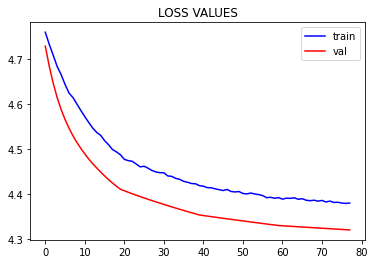

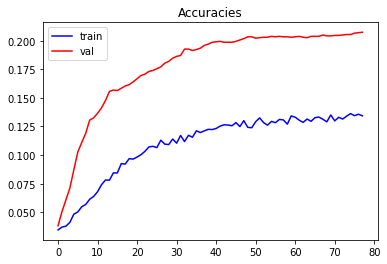

In [ ]:
 # Plotting Loss and Accuracy curves

plt.figure(1)
plt.plot(train_losses, 'b')
plt.plot(val_losses, 'r')
plt.legend(["train", "val"])
plt.title('LOSS VALUES')

plt.figure(2)
plt.plot(tr_accs, 'b')
plt.plot(val_accs, 'r')
plt.legend(["train", "val"])
plt.title('Accuracies')

plt.show()